# Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 18.07.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../utils")

In [3]:
import os
import warnings
from datetime import datetime

import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable

from nichecompass.benchmarking import compute_benchmarking_metrics
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

import scanpy as sc

from ablation_utils import *

### 1.2 Define Parameters

In [4]:
latent_key = "nichecompass_latent"
spatial_key = "spatial"
latent_knng_key = "nichecompass_latent_knng"
spatial_knng_key = "spatial_knng"
gp_names_key = "nichecompass_gp_names"

### 1.4 Run Notebook Setup

In [5]:
sc.set_figure_params(figsize=(6, 6))

In [6]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [8]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8999")

### 1.5 Configure Paths and Directories

In [9]:
artifact_folder_path = f"../../artifacts"
miscellaneous_folder_path = f"{artifact_folder_path}/miscellaneous"
figure_folder_path = f"{miscellaneous_folder_path}/ablation"

## 2. Ablation

### 2.1 Loss Weights, Gene Program Mask & Number of Neighbors

- Three single sample datasets are used (batch1 of Xenium Human Breast Cancer, batch1 of STARmap PLUS Mouse CNS, batch2 of Vizgen MERFISH Human Ovarian Cancer).
- Different combinations of the edge reconstruction loss, gene expression reconstruction loss, and KL divergence weighting hyperparameters are tested.
- Number of neighbors of the spatial neighborhood graph is varied between ```4```, ```8```, ```12```, and ```16```.
- GP mask is varied between fully connected gene program mask, unfiltered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=1.0), weakly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.1), strongly filtered NicheCompass default GP mask (nichenet_keep_target_genes_ratio=0.01).
- This results in a total of 208 (4x4x3x3) + (2x2x4x4) runs per dataset.

In [ ]:
ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [3, 4, 5]

ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["gcs", "mlami", "cas", "clisis", "nasw", "cari", "cnmi", "casw", "clisi"]
metric_col_weights = [1., 1., 1., 1., 2., 0.5, 0.5, 0.5, 0.5]
metric_col_titles = ["Graph Connectivity Similarity",
                     "Maximum Leiden Adjusted Mutual Info",
                     "Cell Type Affinity Similarity",
                     "Cell Type Local Inverse Simpson's Index Similarity",
                     "Niche Average Silhouette Width",
                     "Cell Type Adjusted Rand Index",
                     "Cell Type Normalized Mutual Info",
                     "Cell Type Average Silhouette Width",
                     "Cell Type Local Inverse Simpson's Index"]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index_col=0)
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    
# Define params of interest
summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [ ]:
# Validate that all runs are ok
# temp
summary_df[summary_df["dataset"] == "vizgen_merfish_human_ovarian_cancer"]["nichenet_keep_target_genes_ratio"].value_counts()

# temp
summary_df[(summary_df["dataset"] == "vizgen_merfish_human_ovarian_cancer") & (summary_df["nichenet_keep_target_genes_ratio"] == 0.01)]["n_neighbors"].value_counts()

In [ ]:
# Split into multiple files for each dataset for parallel metrics computation
for dataset in datasets:
    j = 0
    for i in np.arange(20, 240, 20):
        dataset_df = summary_df[summary_df["dataset"] == dataset]
        temp_df = dataset_df[j:i]
        temp_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
        j = i

Now run respective jobs in ```../notebooks/slurm_job_submission.ipynb```.

In [ ]:
# tmp
datasets = ["starmap_plus_mouse_cns"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(20, 240, 20):
        metadata_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
        metrics_df = pd.read_csv(f"{ablation_folder_path}/tmp/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv_metrics_temp.csv")
        metrics2_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv_metrics_temp.csv")
        iteration_df = metadata_df.merge(metrics_df,on=["dataset", "timestamp"], how="left")
        iteration_df.drop("Unnamed: 0_x", axis=1, inplace=True)
        iteration_df.drop("Unnamed: 0_y", axis=1, inplace=True)
        iteration_df = iteration_df.merge(metrics2_df, on=["dataset", "timestamp"], how="left")
        iteration_df.drop("Unnamed: 0", axis=1, inplace=True)
        iteration_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv", index=False)
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)
        
# temp
df1 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics_temp_first.csv")
df2 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics_temp_second.csv")
df3 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics_temp_third.csv")
df4 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics_temp_fourth.csv")

summary_df = summary_df.set_index(['dataset', 'timestamp'])
df1 = df1.set_index(['dataset', 'timestamp'])
df2 = df2.set_index(['dataset', 'timestamp'])
df3 = df3.set_index(['dataset', 'timestamp'])
df4 = df4.set_index(['dataset', 'timestamp'])
summary_df = summary_df.combine_first(df1)
summary_df = summary_df.combine_first(df2)
summary_df = summary_df.combine_first(df3)
summary_df = summary_df.combine_first(df4)

summary_df.reset_index(inplace=True)
summary_df.drop("Unnamed: 0", axis=1, inplace=True)
        
df_extra1 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_extra1_metrics.csv")
df_extra1.drop("Unnamed: 0", axis=1, inplace=True)
df_extra1.drop("Unnamed: 0.1", axis=1, inplace=True)
summary_df = pd.concat([summary_df, df_extra1], ignore_index=True)

summary_df = summary_df[summary_df["timestamp"] != "29062023_161622_1"]
summary_df = summary_df[summary_df["timestamp"] != "29062023_161622_2"]
summary_df = summary_df[summary_df["timestamp"] != "29062023_161622_6"]
summary_df = summary_df[summary_df["timestamp"] != "30062023_100000_1"]

summary_df["lger"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)

summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

summary_df = summary_df[['dataset', 'timestamp', 'n_neighbors', 'gp_mask', 'loss_weights', 'add_fc_gps_instead_of_gp_dict_gps', 'nichenet_keep_target_genes_ratio',
'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'val_auroc_score', 'val_gene_expr_mse_score',
'gcs', 'mlami', 'cas', 'clisis','nasw', 'lger', 'cnmi', 'cari', 'casw', 'clisi']]

summary_df.to_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_starmap_plus_mouse_cns_metrics_final.csv")

summary_df[summary_df['gcs'].isnull()]

In [ ]:
# tmp
datasets = ["xenium_human_breast_cancer"]

summary_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(20, 240, 20):
        metadata_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv")
        metrics_df = pd.read_csv(f"{ablation_folder_path}/tmp/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}.csv_metrics_temp.csv")
        metrics2_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics_temp.csv")
        iteration_df = metadata_df.merge(metrics_df,on=["dataset", "timestamp"], how="left")
        iteration_df.drop("Unnamed: 0_x", axis=1, inplace=True)
        iteration_df.drop("Unnamed: 0_y", axis=1, inplace=True)

        iteration_df = iteration_df.set_index(['dataset', 'timestamp'])
        metrics2_df = metrics2_df.rename(columns={"casw_y": "casw",
                                          "mlami_y": "mlami",
                                         "cas_y": "cas",
                                         "cari_y": "cari",
                                         "clisi_y": "clisi",
                                         "clisis_y": "clisis"})
        #print(metrics2_df)
        metrics2_df = metrics2_df[["dataset", "timestamp", "mlami", "cas", "clisis", "cari", "casw", "clisi"]]
        metrics2_df = metrics2_df.set_index(['dataset', 'timestamp'])
        iteration_df = iteration_df.combine_first(metrics2_df)
        iteration_df.reset_index(inplace=True)
        
        #iteration_df = iteration_df.merge(metrics2_df, on=["dataset", "timestamp"], how="left")
        #iteration_df.drop("Unnamed: 0", axis=1, inplace=True)
        #iteration_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv", index=False)
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)
        
df_extra3 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_xenium_human_breast_cancer_extra3_metrics.csv", index_col=0)
df_extra3.drop("Unnamed: 0", axis=1, inplace=True)
summary_df = pd.concat([summary_df, df_extra3], ignore_index=True)

df_extra2 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_xenium_human_breast_cancer_extra2_metrics.csv")
df_extra2.drop("Unnamed: 0", axis=1, inplace=True)
df_extra2.drop("Unnamed: 0.1", axis=1, inplace=True)

summary_df = summary_df.set_index(['dataset', 'timestamp'])
df_extra2 = df_extra2.set_index(['dataset', 'timestamp'])
summary_df = summary_df.combine_first(df_extra2)
summary_df.reset_index(inplace=True)

summary_df = summary_df[summary_df["timestamp"] != "28062023_164600_1"]
summary_df = summary_df[summary_df["timestamp"] != "28062023_164601_9"]

df_extra1 = pd.read_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_xenium_human_breast_cancer_extra1_metrics.csv")
df_extra1.drop("Unnamed: 0", axis=1, inplace=True)
df_extra1.drop("Unnamed: 0.1", axis=1, inplace=True)
summary_df = pd.concat([summary_df, df_extra1], ignore_index=True)

summary_df['clisis'] = summary_df['clisis'].fillna(0.0)

summary_df["lger"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)

summary_df["loss_weights"] = summary_df.apply(lambda row: get_loss_weights(row), axis=1)
summary_df["gp_mask"] = summary_df.apply(lambda row: get_gp_mask(row), axis=1)
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

summary_df = summary_df[['dataset', 'timestamp', 'n_neighbors', 'gp_mask', 'loss_weights', 'add_fc_gps_instead_of_gp_dict_gps', 'nichenet_keep_target_genes_ratio',
'lambda_edge_recon_', 'lambda_gene_expr_recon_', 'val_auroc_score', 'val_gene_expr_mse_score',
'gcs', 'mlami', 'cas', 'clisis','nasw', 'lger', 'cnmi', 'cari', 'casw', 'clisi']]

summary_df.to_csv("../../artifacts/loss_weights_ablation/mlflow_summary_loss_weights_ablation_xenium_human_breast_cancer_metrics_final.csv")

In [ ]:
# tmp
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns"]
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics_final.csv", index_col=0)
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)
    
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [24]:
metric_cols = ["gcs", "mlami", "cas", "clisis", "nasw", "lger", "cari", "cnmi", "casw", "clisi"]
metric_col_weights = [0.5, 0.5, 0.5, 0.5, 1.5, 1.5, 0.25, 0.25, 0.25, 0.25]
metric_col_titles = ["Graph Connectivity Similarity",
                     "Maximum Leiden Adjusted Mutual Info",
                     "Cell Type Affinity Similarity",
                     "Cell Type Local Inverse Simpson's Index Similarity",
                     "Niche Average Silhouette Width",
                     "Linear Gene Expression Reconstruction",
                     "Cell Type Adjusted Rand Index",
                     "Cell Type Normalized Mutual Info",
                     "Cell Type Average Silhouette Width",
                     "Cell Type Local Inverse Simpson's Index"]

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("loss_weights").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Loss Weights Ablation",
    df=summary_df,
    group_col="loss_weights",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]

    # Compute overall score and determine boxplot ablation col order
    dataset_df["overall_score"] = np.average(dataset_df[metric_cols], weights=metric_col_weights, axis=1)
    order = dataset_df.groupby("loss_weights").mean("overall_score").sort_values("overall_score", ascending=False).index

    # Generate loss weights boxplots
    plot_metrics_boxplot(
        fig_title=f"Loss Weights Ablation {dataset}",
        df=dataset_df,
        group_col="loss_weights",
        metric_cols=metric_cols + ["overall_score"],
        metric_col_titles=metric_col_titles + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=figure_folder_path,
        file_name=f"loss_weights_ablation_metrics_{dataset}.png")

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("gp_mask").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="GP Mask Ablation",
    df=summary_df,
    group_col="gp_mask",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="gp_mask_ablation_metrics.png")

In [ ]:
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]

    # Compute overall score and determine boxplot ablation col order
    dataset_df["overall_score"] = np.average(dataset_df[metric_cols], weights=metric_col_weights, axis=1)
    order = dataset_df.groupby("gp_mask").mean("overall_score").sort_values("overall_score", ascending=False).index

    # Generate loss weights boxplots
    plot_metrics_boxplot(
        fig_title=f"GP Mask Ablation {dataset}",
        df=dataset_df,
        group_col="gp_mask",
        metric_cols=metric_cols + ["overall_score"],
        metric_col_titles=metric_col_titles + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=figure_folder_path,
        file_name=f"gp_mask_ablation_metrics_{dataset}.png")

In [ ]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("n_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Number of Neighbors Ablation",
    df=summary_df,
    group_col="n_neighbors",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="n_neighbors_ablation_metrics.png")

In [ ]:
for dataset in datasets:
    dataset_df = summary_df[summary_df["dataset"] == dataset]

    # Compute overall score and determine boxplot ablation col order
    dataset_df["overall_score"] = np.average(dataset_df[metric_cols], weights=metric_col_weights, axis=1)
    order = dataset_df.groupby("n_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

    # Generate loss weights boxplots
    plot_metrics_boxplot(
        fig_title=f"Number of Neighbors Ablation {dataset}",
        df=dataset_df,
        group_col="n_neighbors",
        metric_cols=metric_cols + ["overall_score"],
        metric_col_titles=metric_col_titles + ["Overall Score"],
        order=order,
        save_fig=True,
        figure_folder_path=figure_folder_path,
        file_name=f"n_neighbors_ablation_metrics_{dataset}.png")

In [ ]:
# Load data
summary_df = pd.DataFrame()
for dataset in datasets:
    for i in np.arange(20, 240, 20):
        iteration_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_{i}_metrics.csv")
        summary_df = pd.concat([summary_df, iteration_df], ignore_index=True)
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_metrics.csv", index=False)

In [ ]:
# Compute overall score
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)

In [ ]:
filtered_df = summary_df[summary_df['gcs'].isnull()]

In [ ]:
filtered_df2 = filtered_df[~filtered_df["timestamp"].isin(["30062023_100000_1", "29062023_161622_6", "29062023_161622_1"])][14:]

In [ ]:
filtered_df2["timestamp"].tolist()

In [ ]:
test_df = summary_df.merge(df1, on=["dataset", "timestamp"], how="left")

In [ ]:
df1

In [ ]:


# Compute overall score
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("loss_weights").mean("overall_score").sort_values("overall_score", ascending=False).index

In [ ]:
filtered_df = summary_df[summary_df['gcs'].isnull()]

In [ ]:
filtered_df

In [ ]:
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_metrics_final.csv", index=False)

In [ ]:
metrics_df = pd.DataFrame()
timestamps = filtered_df2["timestamp"].tolist()
# Compute metrics for ablation runs models
dataset_metrics_df = compute_metrics(
    artifact_folder_path=artifact_folder_path,
    dataset=dataset,
    task="loss_weights_ablation",
    timestamps=timestamps,
    cell_type_key="Main_molecular_cell_type",
    batch_key=None,
    spatial_key="spatial",
    latent_key="nichecompass_latent",
    metrics=metric_cols,
    file_name=f"mlflow_summary_loss_weights_ablation_{dataset}.csv")
metrics_df = pd.concat([metrics_df, dataset_metrics_df],
                       axis=0)

In [ ]:
# Generate loss weights boxplots
order = summary_df.groupby("loss_weights").mean("overall_score").sort_values("overall_score", ascending=False).index

plot_metrics_boxplot(
    fig_title="Loss Weights Ablation",
    df=summary_df,
    group_col="loss_weights",
    metric_cols=["val_auroc_score", "val_gene_expr_mse_score"] + metric_cols + ["overall_score"],
    metric_col_titles=["Val AUROC", "Val Gene Expr MSE"] + metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
summary_df

In [ ]:
# Generate gp mask boxplots
order = summary_df.groupby("gp_mask").mean("overall_score").sort_values("overall_score", ascending=False).index

plot_metrics_boxplot(
    fig_title="GP Mask Ablation",
    df=summary_df,
    group_col="gp_mask",
    metric_cols=["val_auroc_score", "val_gene_expr_mse_score"] + metric_cols + ["overall_score"],
    metric_col_titles=["Val AUROC", "Val Gene Expr MSE"] + metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="gp_mask_ablation_metrics.png")

In [ ]:
# Generate gp mask boxplots
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype("str")
order = summary_df.groupby("n_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

plot_metrics_boxplot(
    fig_title="Number of Neighbors Ablation",
    df=summary_df,
    group_col="n_neighbors",
    metric_cols=["val_auroc_score", "val_gene_expr_mse_score"] + metric_cols + ["overall_score"],
    metric_col_titles=["Val AUROC", "Val Gene Expr MSE"] + metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=True,
    figure_folder_path=figure_folder_path,
    file_name="n_neighbors_ablation_metrics.png")

In [ ]:
# Prepare metrics table plot
aggregate_df = summary_df.groupby(["dataset", "loss_weights"]).mean("overall_score").sort_values("overall_score", ascending=False)[metric_cols].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols,
   var_name="score_type", 
   value_name="score")

# Bring df in right order for table
unrolled_df = unrolled_df.sort_values("dataset")

In [ ]:
summary_df.groupby(["dataset", "loss_weights"]).mean()["cnmi"]

In [ ]:
summary_df.groupby(["loss_weights"]).mean()["gcs"]

In [ ]:
plot_metrics_table(
    df=unrolled_df,
    ablation_col=ablation_col,
    ablation_col_width=5,
    group_col=dataset_col,
    metric_cols=metric_cols,
    metric_col_weights=metric_col_weights,
    metric_col_width=0.7,
    plot_width=18,
    plot_height=15,
    show=True,
    save_dir=None,
    save_name="ablation_results.svg")

In [ ]:
summary_df.sort_values("nasw", ascending=False).head(60)

In [ ]:
artifact_folder_path

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["01072023_101716_27"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            dataset="xenium_human_breast_cancer",
                            task="loss_weights_ablation",
                            timestamps=["30062023_143855_10"],
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=50.,
                            save_fig=False)

In [ ]:
# Remove runs with 0 lambda for both losses
summary_df = summary_df[summary_df["loss_weights"] != "lambda_edge_recon_0.0_+_lambda_gene_expr_recon_0.0"]

In [ ]:
# GP mask plot
plot_metrics(fig_title="Gene Program Mask Ablation",
             df=summary_df,
             group_col="gp_mask",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score", "gcs", "nasw", "cnmi", "metrics_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="gp_mask_ablation_metrics.png")

In [ ]:
summary_df["n_neighbors"] = summary_df["n_neighbors"].astype(str)

In [ ]:
# Number of neighbors plot
plot_metrics(fig_title="Number of Neighbors Ablation",
             df=summary_df,
             group_col="n_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score", "gcs", "nasw", "cnmi", "metrics_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="n_neighbors_ablation_metrics.png")

In [ ]:
# GP mask plot
plot_metrics(fig_title="Gene Program Mask Ablation",
             df=summary_df,
             group_col="n_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=False,
             figure_folder_path=figure_folder_path,
             file_name="gp_mask_ablation_metrics.png")

In [ ]:
ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["cas", "mlami", "gcs", "cca"]
metric_cols_weights = [0.6, 0.6, 0.6, 0.4]
metric_score_cols = [metric_col + "_points" for metric_col in metric_cols]

# Compute ablation points
points_df = compute_ablation_points(
    df=test_df,
    group_col=ablation_col,
    metric_cols=metric_cols,
    metric_cols_weights=metric_cols_weights,
    sort_metric_col="total_score")

In [ ]:
# Plot metrics
for dataset in datasets:
    dataset_df = points_df[points_df["dataset"] == dataset]
    plot_metrics(
        fig_title=f"Loss Weights Ablation: {dataset}",
        df=dataset_df,
        group_col="loss_weights",
        metric_cols=metric_cols,
        plot_ratio_active_gps=False,
        save_fig=False,
        file_name="ablation_metrics.png")

In [ ]:
ablation_col = "loss_weights"
dataset_col = "dataset"
group_cols = [dataset_col] + [ablation_col]
metric_cols = ["cas", "mlami", "gcs", "cca"]
metric_cols_weights = [0.6, 0.6, 0.6, 0.4]
metric_score_cols = [metric_col + "_points" for metric_col in metric_cols]

In [ ]:
# Unroll points df and compute means over group columns and score type
unrolled_points_df = pd.melt(points_df, 
   id_vars=group_cols,
   value_vars=metric_score_cols,
   var_name="score_type", 
   value_name="score")

# Compute metric means over all runs
mean_points_df = unrolled_points_df.groupby(group_cols + ["score_type"]).mean()
mean_points_df.reset_index(inplace=True)

In [ ]:
mean_points_df

In [ ]:
plot_ablation_points(df=mean_points_df,
                     ablation_col=ablation_col,
                     ablation_col_width=7,
                     group_col=dataset_col,
                     metric_cols=metric_score_cols,
                     show=True,
                     save_dir=None,
                     save_name="ablation_results.svg")

In [ ]:
visualize_latent_embeddings(artifact_folder_path=artifact_folder_path,
                            plot_label="test",
                            task=ablation_task + "_ablation",
                            timestamps=timestamps,
                            dataset="xenium_human_breast_cancer",
                            cat_key="cell_states",
                            sample_key="batch",
                            groups=None,
                            spot_size=30.,
                            save_fig=False)

### 2.2 Neighbor Sampling

In [10]:
ablation_task = "neighbor_sampling"
cross_ablation_task = "loss_weights" # for comparison with no neighbor sampling
datasets = ["xenium_human_breast_cancer", "starmap_plus_mouse_cns", "vizgen_merfish_human_ovarian_cancer"]
cell_type_keys = ["cell_states", "Main_molecular_cell_type", "cell_type"]
batch_keys = [None, None, None]
experiment_ids = [9, 10, 11]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_gene_expr_mse_score"] = run.data.metrics.get("val_gene_expr_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_sampled_neighbors"] = run.data.params["n_sampled_neighbors_"]
        run_dict["nichenet_keep_target_genes_ratio"] = run.data.params["nichenet_keep_target_genes_ratio"]        
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv", index=False)

In [11]:
# tmp
datasets = ["starmap_plus_mouse_cns"]

In [12]:
# Load metrics and params of ablation runs from disk
summary_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")
    summary_df = pd.concat([summary_df, dataset_df], ignore_index=True)

summary2_df = pd.DataFrame()
for dataset in datasets:
    dataset_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_{dataset}.csv", index_col=0)
    summary2_df = pd.concat([summary2_df, dataset_df], ignore_index=True)

In [13]:
# Only keep relevant runs and params from previous ablation
summary2_df = summary2_df[(summary2_df["lambda_edge_recon_"] == 500000.0) &
           (summary2_df["lambda_gene_expr_recon_"] == 300.0) &
           (summary2_df["nichenet_keep_target_genes_ratio"] == 0.01)][
    ["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "n_neighbors"]]

summary2_df["n_sampled_neighbors"] = -1 # No neighbor sampling

# tmp
summary_df = summary_df[(summary_df["nichenet_keep_target_genes_ratio"] == 1.0)]

In [47]:
# tmp
summary_df = pd.read_csv("../../artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_1_metrics.csv", index_col=0)
summary_df["lger"] = summary_df.loc[:, 'val_gene_expr_mse_score'].apply(scale_metric)
summary2_df = pd.read_csv(f"{ablation_folder_path.replace(ablation_task, cross_ablation_task)}/mlflow_summary_{cross_ablation_task}_ablation_{dataset}_metrics_final.csv", index_col=0)

# Only keep relevant runs and params from previous ablation
summary2_df = summary2_df[(summary2_df["lambda_edge_recon_"] == 500000.0) &
           (summary2_df["lambda_gene_expr_recon_"] == 300.0) &
           (summary2_df["nichenet_keep_target_genes_ratio"] == 1.0)][
    ["dataset", "timestamp", "val_auroc_score", "val_gene_expr_mse_score", "n_neighbors", "nichenet_keep_target_genes_ratio"] + metric_cols]

summary2_df["n_sampled_neighbors"] = -1 # No neighbor sampling

summary_df = pd.concat([summary_df, summary2_df], ignore_index=True)
summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [48]:
summary_df

,dataset,timestamp,val_auroc_score,val_gene_expr_mse_score,n_neighbors,n_sampled_neighbors,nichenet_keep_target_genes_ratio,gcs,mlami,cas,clisis,nasw,cnmi,cari,casw,clisi,lger
0,starmap_plus_mouse_cns,19072023_023451_2000,0.997939,0.637154,12,8,1.0,0.940599,0.729113,0.873561,0.961707,0.621154,0.320657,0.140530,0.496281,0.959965,0.638851
1,starmap_plus_mouse_cns,19072023_022320_1002,0.998225,0.651899,16,4,1.0,0.947709,0.771146,0.914421,0.966243,0.599308,0.322499,0.164931,0.494720,0.958357,0.632219
2,starmap_plus_mouse_cns,19072023_015429_1001,0.998000,0.640661,12,4,1.0,0.948564,0.742232,0.898781,0.963738,0.603881,0.324899,0.170958,0.496786,0.959032,0.637266
3,starmap_plus_mouse_cns,19072023_004219_1000,0.996543,0.643298,8,4,1.0,0.940248,0.688795,0.815144,0.956803,0.635657,0.337339,0.168682,0.500064,0.961197,0.636077
4,starmap_plus_mouse_cns,19072023_003250_4,0.996926,0.689749,16,2,1.0,0.953750,0.758073,0.913540,0.967167,0.573452,0.327866,0.147895,0.496549,0.958352,0.615601
5,starmap_plus_mouse_cns,19072023_002026_3,0.995943,0.699218,12,2,1.0,0.950484,0.712949,0.891168,0.962963,0.599464,0.343663,0.178447,0.500571,0.959393,0.611534
6,starmap_plus_mouse_cns,19072023_001813_2,0.995080,0.676093,8,2,1.0,0.944239,0.673692,0.786816,0.957228,0.640626,0.345434,0.167566,0.503350,0.960994,0.621529
7,starmap_plus_mouse_cns,18072023_231831_1,0.988905,0.650930,4,2,1.0,0.922649,0.599076,0.637030,0.942908,0.647562,0.361991,0.199625,0.507878,0.966298,0.632652
8,starmap_plus_mouse_cns,29062023_213538_41,0.984324,0.520738,4,-1,1.0,0.922189,0.591891,0.590891,0.942620,0.647456,0.359581,0.216413,0.503866,0.966137,0.694359
9,starmap_plus_mouse_cns,29062023_213810_42,0.994087,0.477651,8,-1,1.0,0.948210,0.673154,0.783507,0.957333,0.622570,0.344529,0.195995,0.501990,0.961188,0.716316


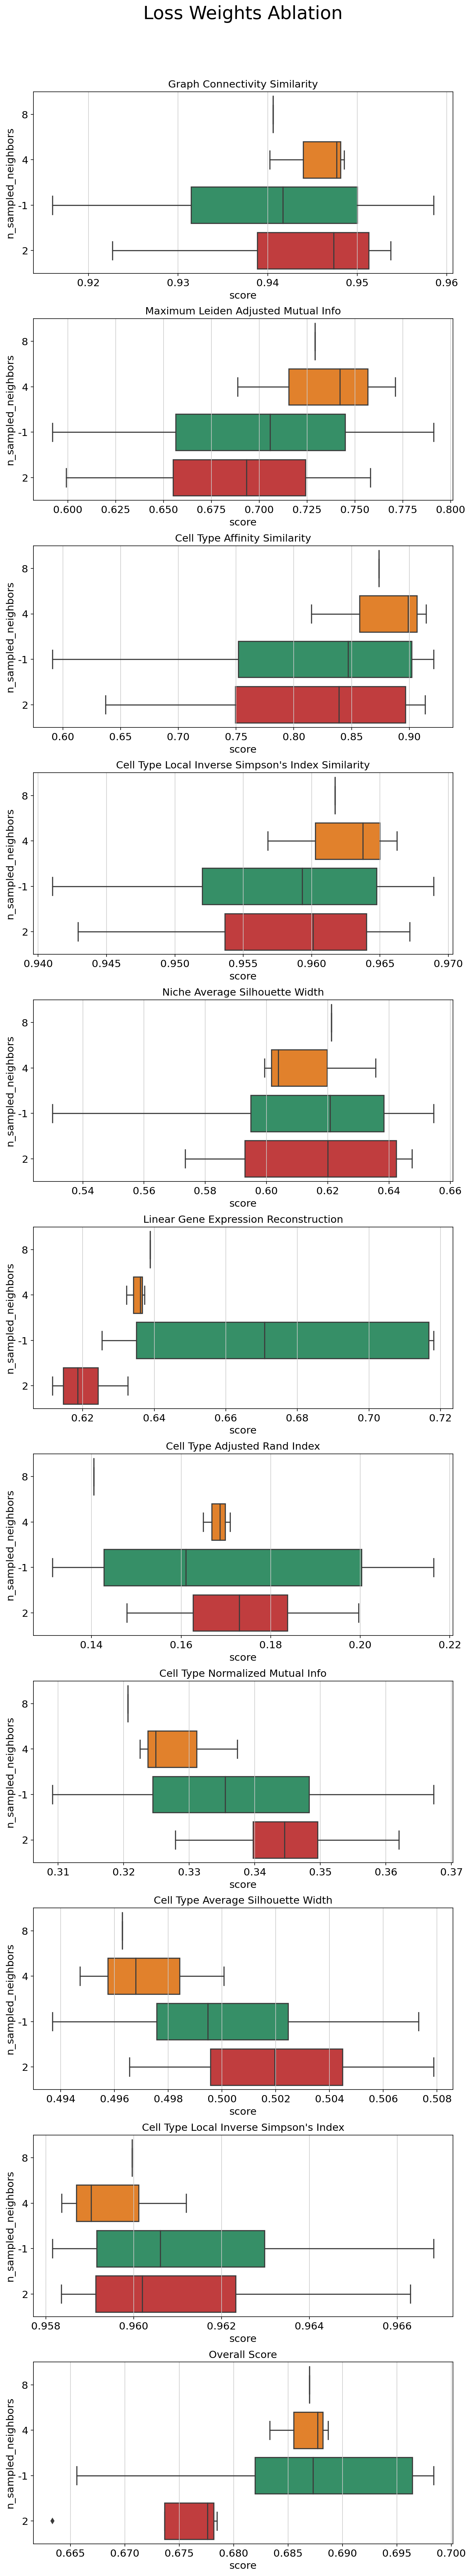

In [49]:
# Compute overall score and determine boxplot ablation col order
summary_df["overall_score"] = np.average(summary_df[metric_cols], weights=metric_col_weights, axis=1)
order = summary_df.groupby("n_sampled_neighbors").mean("overall_score").sort_values("overall_score", ascending=False).index

# Generate loss weights boxplots
plot_metrics_boxplot(
    fig_title="Loss Weights Ablation",
    df=summary_df,
    group_col="n_sampled_neighbors",
    metric_cols=metric_cols + ["overall_score"],
    metric_col_titles=metric_col_titles + ["Overall Score"],
    order=order,
    save_fig=False,
    figure_folder_path=figure_folder_path,
    file_name="loss_weights_ablation_metrics.png")

In [ ]:
workspace/projects/nichecompass-reproducibility/artifacts/neighbor_sampling_ablation/mlflow_summary_neighbor_sampling_ablation_starmap_plus_mouse_cns_1_metrics.csv

In [ ]:
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}_1.csv", index=False)

In [ ]:
summary_df_filtered = summary_df[(summary_df["n_neighbors"].isin([4, 8, 12, 16])) & (summary_df["n_sampled_neighbors"] == 4)]
summary_df = pd.concat([summary_df_filtered, summary2_df], ignore_index=True)
summary_df["n_sampled_neighbors"] = summary_df["n_sampled_neighbors"].astype(str)

In [ ]:
summary_df.to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_processed.csv", index=False)

In [ ]:
summary_df

In [ ]:
# Neighbor sampling comparison vs without plot
plot_metrics(fig_title="Neighbor Sampling Ablation",
             df=summary_df,
             group_col="n_sampled_neighbors",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="neighbor_sampling_ablation_metrics.png")

### 2.3 Encoder Architecture

In [ ]:
ablation_task = "encoder_architecture"
cross_ablation_task = "loss_weights"
datasets = ["xenium_human_breast_cancer"]
cell_type_keys = ["cell_states"]
batch_keys = [None]
experiment_ids = [7]

ablation_folder_path = f"{artifact_folder_path}/{ablation_task}_ablation"
os.makedirs(ablation_folder_path, exist_ok=True)

In [ ]:
# Retrieve metrics and params of ablation runs from mlflow and save to disk
summary_df = pd.DataFrame()
for dataset, experiment_id in zip(datasets, experiment_ids):
    runs_info = mlflow.list_run_infos(experiment_id)
    for run_info in runs_info:
        run = mlflow.get_run(run_info.run_uuid)
        if run.info.status == "RUNNING":
            continue
        run_dict = {"dataset": dataset}
        run_dict["timestamp"] = run.data.params["timestamp"]
        run_dict["val_auroc_score"] = run.data.metrics.get("val_auroc_score", np.nan)
        run_dict["val_gene_expr_mse_score"] = run.data.metrics.get("val_gene_expr_mse_score", np.nan)
        run_dict["n_neighbors"] = run.data.params["n_neighbors"]
        run_dict["n_layers_encoder"] = run.data.params["n_layers_encoder_"]
        run_dict["conv_layer_encoder"] = run.data.params["conv_layer_encoder_"]
        run_df = pd.DataFrame(run_dict, index=[0])
        summary_df = pd.concat([summary_df, run_df], ignore_index=True)

for dataset in datasets:
    summary_df[summary_df["dataset"] == dataset].to_csv(f"{ablation_folder_path}/mlflow_summary_{ablation_task}_ablation_{dataset}.csv")

In [ ]:
summary_df = summary_df[summary_df["n_neighbors"].isin(["4", "8"])]

In [ ]:
# GATv2 vs GCN plot
plot_metrics(fig_title="Encoder Layer Type Ablation",
             df=summary_df,
             group_col="conv_layer_encoder",
             metric_cols=["val_auroc_score", "val_gene_expr_mse_score"],
             save_fig=True,
             figure_folder_path=figure_folder_path,
             file_name="encoder_layer_type_ablation_metrics.png")

#### 2.1.2 Categorical Covariates Contrastive Loss

### 2.5 Spatial Neighborhood Graph

In [ ]:
visualize_niches(artifact_folder_path=artifact_folder_path,
                 dataset=dataset,
                 task=ablation_task + "_ablation",
                 timestamps=timestamps,
                 sample_key="batch",
                 latent_key=latent_key,
                 latent_leiden_resolution=0.2,
                 latent_cluster_key="nichecompass_latent_clusters",
                 spot_size=30.)

### 2.5 Gene Program Mask

In [ ]:
"""
# Log additional mlflow param
run_ids = []
runs_info = mlflow.list_run_infos(3)
for run_info in runs_info:
    run = mlflow.get_run(run_info.run_uuid)
    if "add_fc_gps_instead_of_gp_dict_gps" not in run.data.params:
        run_ids.append(run_info.run_uuid)
        
for run_id in run_ids:
    with mlflow.start_run(run_id=run_id) as run:
        mlflow.log_param("add_fc_gps_instead_of_gp_dict_gps", True)
"""